In [2]:
import statsmodels
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os 
import datetime as datetime
from scipy.optimize import minimize
from scipy import optimize

In [3]:
#estimated_data = pd.read_csv("../data/data_for_parm_estimation_update_v2.csv")
estimated_data = pd.read_csv("../data/data_for_parm_estimation_short_series.csv")
futures_data = pd.read_csv("../data/futures_data.csv")
parm_jump_dict = {'frequency': 0.024413145539906103,
     'prob_positive': 0.34615384615384615,
     'prob_negative': 0.6538461538461539,
     'nu_positive': 0.020015373534093116,
     'nu_negative': 0.0557837194720546,
     'mean_rev_jump': 1.09007164790174}


alpha_ou = 0.3636

In [4]:
estimated_data

,date,price,weekday,days_from_start,buss_day,spike_vec,spike_vec_w_sign,ou_estim_vec,fitted_vals
0,2002-01-01,14.931667,Tue,0,buss_day,0.0,0.0,-9.134850,24.066517
1,2002-01-02,28.747917,Wed,1,buss_day,0.0,0.0,4.477120,24.270797
2,2002-01-03,31.267083,Thu,2,buss_day,0.0,0.0,6.979399,24.287685
3,2002-01-04,34.210833,Fri,3,buss_day,0.0,0.0,11.923250,22.287584
4,2002-01-05,27.526667,Sat,4,buss_day,0.0,0.0,10.370997,17.155670
...,...,...,...,...,...,...,...,...,...
1060,2004-11-26,34.312917,Fri,1060,buss_day,0.0,0.0,1.120430,33.192486
1061,2004-11-27,26.077500,Sat,1061,buss_day,0.0,0.0,0.527878,25.549622
1062,2004-11-28,21.265417,Sun,1062,buss_day,0.0,0.0,1.973046,19.292370
1063,2004-11-29,34.888333,Mon,1063,buss_day,0.0,0.0,0.677581,34.210753


In [5]:
estimated_data['date'] = pd.to_datetime(estimated_data['date'])
futures_data[['notationtime','delivery_start','delivery_end']] = futures_data[['notationtime','delivery_start','delivery_end']].apply(lambda x: pd.to_datetime(x))

In [6]:
estimated_data = estimated_data.rename(columns={'date':'notationtime'})

In [7]:
def aux_bar(data_in: pd.DataFrame
              , param_input: float
              , diff_t_t1=None
              , diff_t_t2=None
              , diff_t1_t2=None):
    if diff_t_t1 is None or diff_t_t2 is None or diff_t1_t2 is None:
        diff_t_t1 = (data_in['delivery_start']-data_in['notationtime']).dt.days
        diff_t_t2 = (data_in['delivery_end']-data_in['notationtime']).dt.days
        diff_t1_t2 = (data_in['delivery_end']-data_in['delivery_start']).dt.days
    
    return -1/param_input * (np.exp(-param_input*diff_t_t2)-np.exp(-param_input*diff_t_t1))

def aux_tilde(data_in: pd.DataFrame
              , param_input: float
              , diff_t_t1=None
              , diff_t_t2=None
              , diff_t1_t2=None):
    if diff_t_t1 is None or diff_t_t2 is None or diff_t1_t2 is None:
        diff_t_t1 = (data_in['delivery_start']-data_in['notationtime']).dt.days
        diff_t_t2 = (data_in['delivery_end']-data_in['notationtime']).dt.days
        diff_t1_t2 = (data_in['delivery_end']-data_in['delivery_start']).dt.days
    
    return 1/param_input * (diff_t1_t2 + 1/param_input * (np.exp(-param_input*diff_t_t2)-np.exp(-param_input*diff_t_t1)))


In [8]:
futures_data["alpha_bar"] = aux_bar(futures_data, alpha_ou)
futures_data["beta_bar"] = aux_bar(futures_data, parm_jump_dict['mean_rev_jump'])

futures_data["alpha_tilde"] = aux_tilde(futures_data, alpha_ou)
futures_data["beta_tilde"] = aux_tilde(futures_data, parm_jump_dict['mean_rev_jump'])

futures_data["diff_t1_t2"] = (futures_data['delivery_end']-futures_data['delivery_start']).dt.days

In [10]:
estimated_data['deterministic'] = estimated_data['fitted_vals']
estimated_data['month-year'] = estimated_data['notationtime'].dt.month.apply(str) + "-" + estimated_data['notationtime'].dt.year.apply(str)


In [11]:
estimated_data['start_of_month'] = estimated_data['notationtime'].to_numpy().astype('datetime64[M]')

In [12]:
determ_sum = estimated_data.groupby(['start_of_month']).apply(lambda x: x.deterministic.sum())
detern_sum_df = determ_sum.to_frame().reset_index().rename(columns={"start_of_month":"delivery_start"
                                                                    , 0:"determ_sum"})

In [13]:
futures_data_determ_sum = futures_data.merge(detern_sum_df
                                            , on='delivery_start'
                                            , how='left')
data_collected = futures_data_determ_sum.merge(estimated_data[['notationtime','spike_vec_w_sign', 'ou_estim_vec']]
                                    , on='notationtime'
                                    , how='left')
data_collected = data_collected.dropna(axis=0).reset_index(drop=True)

In [59]:
def psi_prime_l1(u:float
                 ,param_jump_dict:dict=None):
    if param_jump_dict is None: 
        param_jump_dict = {'frequency': 0.024413145539906103,
                           'prob_positive': 0.34615384615384615,
                           'prob_negative': 0.6538461538461539,
                           'nu_positive': 0.020015373534093116,
                           'nu_negative': 0.0557837194720546,
                           'mean_rev_jump': 1.09007164790174}
    lam = param_jump_dict['frequency']
    p = param_jump_dict['prob_positive']
    q = param_jump_dict['prob_positive']
    nu_1 = param_jump_dict['nu_positive']
    nu_2 = param_jump_dict['nu_negative']
    
    return (-lam*p/(u-nu_1)) + (lam*p*u/((u-nu_1)**2)) + (lam*q/(u-nu_2)) + (-lam*q*u/((u-nu_2)**2))

In [17]:
def calculate_f_u_q(input_param
                    , data_inp=None):
    if data_inp is None: 
        data_inp = data_collected.query("forward_month == 'M1'")
    
    theta_w, theta_l = input_param
    return  1/data_inp.diff_t1_t2 * (data_inp.determ_sum \
                                    + data_inp.alpha_bar * data_inp.ou_estim_vec \
                                    + data_inp.beta_bar * data_inp.spike_vec_w_sign \
                                    + theta_w * data_inp.alpha_tilde \
                                    + psi_prime_l1(theta_l) * data_inp.beta_tilde )



In [18]:
def optim_function(input_parm
                   , data_inp=None):
        
        model_price = calculate_f_u_q(input_parm, data_inp)
        
        return np.sum((data_inp.price.to_numpy() - model_price.to_numpy())**2)

def optim_function_mae(input_parm
                   , data_inp=None):
        
        model_price = calculate_f_u_q(input_parm, data_inp)
        
        return np.sum(np.abs((data_inp.price.to_numpy() - model_price.to_numpy())))

## Find the market risk parameters for all the granularities

In [26]:
# legacy code name
data_init_period = data_collected
bounds = [[-1.5,1.7], [-1.5,1.5]]

In [181]:
opt_parm_SLSQP_m1 = minimize(optim_function, [0.1,0.1], args=data_collected.query("forward_month == 'M1'"), method='SLSQP',options={'disp': True})
opt_parm_SLSQP_m2 = minimize(optim_function, [0.1,0.1], args=data_collected.query("forward_month == 'M2'"), method='SLSQP',options={'disp': True})
opt_parm_SLSQP_m3 = minimize(optim_function, [0.1,0.1], args=data_collected.query("forward_month == 'M3'"), method='SLSQP',options={'disp': True})
opt_parm_SLSQP_m4 = minimize(optim_function, [0.1,0.1], args=data_collected.query("forward_month == 'M4'"), method='SLSQP',options={'disp': True})
dict_parm = {'m1':opt_parm_SLSQP_m1['x']
            , 'm2':opt_parm_SLSQP_m2['x']
            , 'm3':opt_parm_SLSQP_m3['x']
            , 'm4':opt_parm_SLSQP_m4['x']}
print(dict_parm)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13411.818740360763
            Iterations: 4
            Function evaluations: 25
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: 15276.309412873303
            Iterations: 4
            Function evaluations: 25
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: 14957.185825600805
            Iterations: 4
            Function evaluations: 25
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10453.67414145985
            Iterations: 5
            Function evaluations: 28
            Gradient evaluations: 5
{'m1': array([1.09707361, 0.57158491]), 'm2': array([1.1827513 , 0.61730869]), 'm3': array([1.06384579, 0.56953709]), 'm4': array([0.76585906, 0.4373296 ])}


In [182]:
dict_parm_dual = {'m1':opt_parm_dual_m1['x']
            , 'm2':opt_parm_dual_m2['x']
            , 'm3':opt_parm_dual_m3['x']
            , 'm4':opt_parm_dual_m4['x']}
print(dict_parm_dual)

{'m1': array([1.7       , 0.07169134]), 'm2': array([ 1.18372498, -0.19042941]), 'm3': array([ 1.06387173, -0.3967602 ]), 'm4': array([ 0.76602322, -0.24763138])}


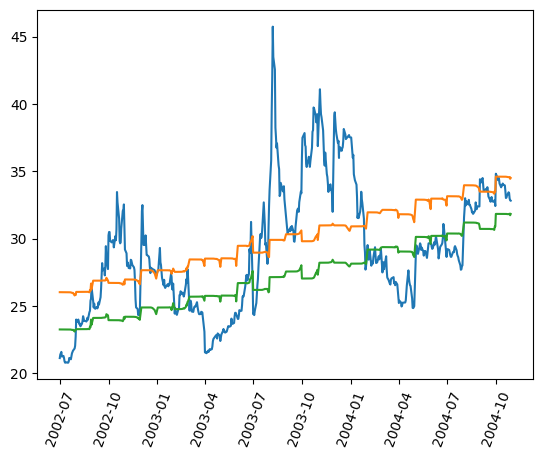

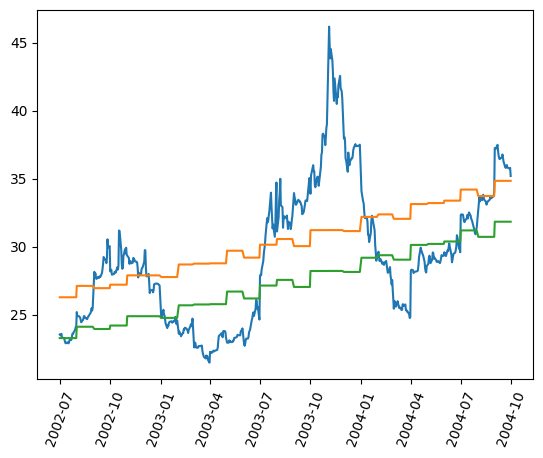

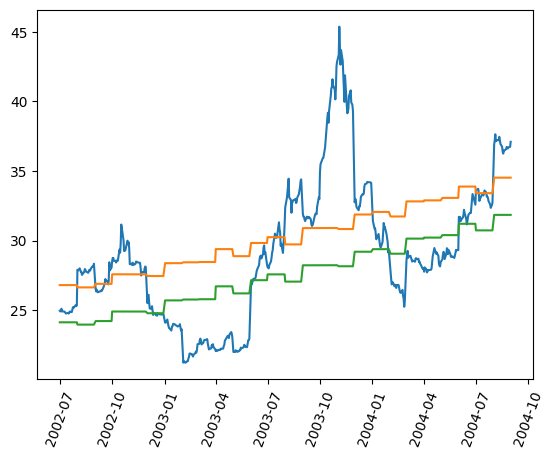

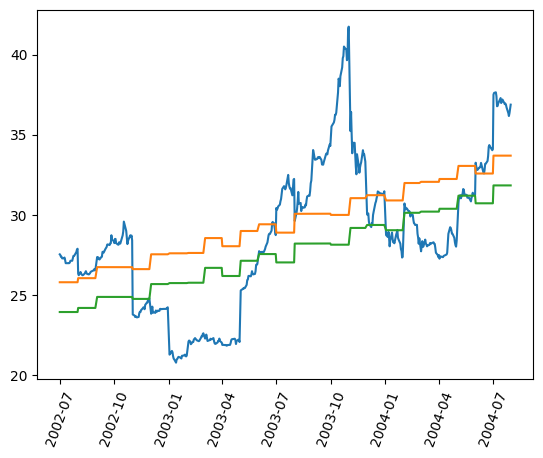

In [187]:
df_plot = data_init_period.query("forward_month == 'M1'").copy()
df_plot['m1_calc_q_theta'] = calculate_f_u_q(dict_parm['m1'],df_plot).to_numpy()
df_plot['m1_calc_p'] = calculate_f_u_q([0,0],df_plot).to_numpy()
df_plot.set_index('notationtime',inplace=True)
plt.plot(df_plot[['price','m1_calc_q_theta','m1_calc_p']])
plt.xticks(rotation=70)
plt.show()
df_plot

df_plot = data_init_period.query("forward_month == 'M2'").copy()
df_plot['m1_calc_q_theta'] = calculate_f_u_q(dict_parm['m2'],df_plot).to_numpy()
df_plot['m1_calc_p'] = calculate_f_u_q([0,0],df_plot).to_numpy()
df_plot.set_index('notationtime',inplace=True)
plt.plot(df_plot[['price','m1_calc_q_theta','m1_calc_p']])
plt.xticks(rotation=70)
plt.show()

df_plot = data_init_period.query("forward_month == 'M3'").copy()
df_plot['m1_calc_q_theta'] = calculate_f_u_q(dict_parm['m3'],df_plot).to_numpy()
df_plot['m1_calc_p'] = calculate_f_u_q([0,0],df_plot).to_numpy()
df_plot.set_index('notationtime',inplace=True)
plt.plot(df_plot[['price','m1_calc_q_theta','m1_calc_p']])
plt.xticks(rotation=70)
plt.show()

df_plot = data_init_period.query("forward_month == 'M4'").copy()
df_plot['m1_calc_q_theta'] = calculate_f_u_q(dict_parm['m4'],df_plot).to_numpy()
df_plot['m1_calc_p'] = calculate_f_u_q([0,0],df_plot).to_numpy()
df_plot.set_index('notationtime',inplace=True)
plt.plot(df_plot[['price','m1_calc_q_theta','m1_calc_p']])
plt.xticks(rotation=70)
plt.show()

In [188]:
df_plot = data_init_period.query("forward_month == 'M1'").copy()
df_plot['calc_under_q_theta'] = calculate_f_u_q(dict_parm['m1'],df_plot).to_numpy()
df_plot['calc_under_p'] = calculate_f_u_q([0,0],df_plot).to_numpy()
df_plot.to_csv("../data/data_future_found/short_period/data_m1_short_period.csv")     


df_plot = data_init_period.query("forward_month == 'M2'").copy()
df_plot['calc_under_q_theta'] = calculate_f_u_q(dict_parm['m2'],df_plot).to_numpy()
df_plot['calc_under_p'] = calculate_f_u_q([0,0],df_plot).to_numpy()
df_plot.to_csv("../data/data_future_found/short_period/data_m2_short_period.csv")  

df_plot = data_init_period.query("forward_month == 'M3'").copy()
df_plot['calc_under_q_theta'] = calculate_f_u_q(dict_parm['m3'],df_plot).to_numpy()
df_plot['calc_under_p'] = calculate_f_u_q([0,0],df_plot).to_numpy()
df_plot.to_csv("../data/data_future_found/short_period/data_m3_short_period.csv")  

df_plot = data_init_period.query("forward_month == 'M4'").copy()
df_plot['calc_under_q_theta'] = calculate_f_u_q(dict_parm['m4'],df_plot).to_numpy()
df_plot['calc_under_p'] = calculate_f_u_q([0,0],df_plot).to_numpy()
df_plot.to_csv("../data/data_future_found/short_period/data_m4_short_period.csv") 

In [ ]:
def 